In [47]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

In [61]:
# Load 'p.jpg' photo
img = cv2.imread('p.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (3840, 2160))

(2160, 3840, 3)
h_exp = 2160, w_exp = 3840
Image shape: (2160, 3840, 3)


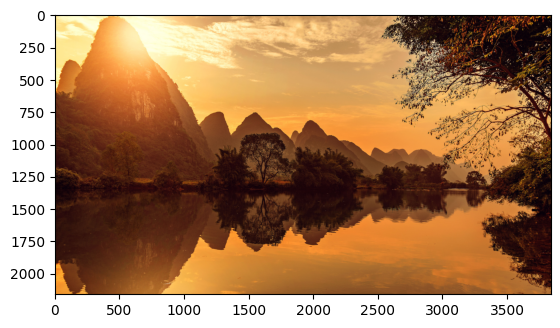

In [62]:
import matplotlib.pyplot as plt

print(img.shape)
h_exp, w_exp = img.shape[:2]
print(f"h_exp = {h_exp}, w_exp = {w_exp}")
print(f"Image shape: {img.shape}")
plt.imshow(img)
plt.show()

In [63]:
# Define height and width
h, w = img.shape[:2]
h, w

(2160, 3840)

In [140]:
height_tile = int(h / 10)
width_tile = int(w / 10)

effective_divisions = 12

width_step = (w - width_tile) // (effective_divisions - 1)
height_step = (h - height_tile) // (effective_divisions - 1)
print(img.shape)

width_boundary = width_step * (effective_divisions - 1) + width_tile
height_boundary = h - height_step * (effective_divisions - 1)

img_list = []
num_div_h = int(h / height_step) # number of columns per division
num_div_y = int(w / width_step) # number of rows per division

def divide_img(img, row=0):
  for i in range(effective_divisions):
    y_start = i * height_step
    y_end = y_start + height_tile

    for j in range(effective_divisions):
      x_start = j * width_step
      x_end = x_start + width_tile
      # If column number is an even number, activate horizontal division
      img_list.append(img[y_start:y_end,
                          x_start:x_end])
      row += 1

(2160, 3840, 3)


In [141]:
divide_img(img)

In [142]:
len(img_list)

144

In [143]:
def preprocess_img(img):
  image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  image = cv2.equalizeHist(image)
  image = cv2.medianBlur(image, 3)
  return image


In [144]:
def homography(img1, img2):
  sift = cv2.SIFT_create()

  # Detect keypoints and descriptors
  kp1, des1 = sift.detectAndCompute(img1, None)
  kp2, des2 = sift.detectAndCompute(img2, None)

  # Use BFMatcher to find matches
  bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
  matches = bf.match(des1, des2)

  # Sort matches by distance
  matches = sorted(matches, key=lambda x: x.distance)

  img_matches = cv2.drawMatches(
      img1, kp1, img2, kp2, matches[:50], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
  cv2_imshow(img_matches)

  # Extract location of good matches
  src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
  dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

  # Compute homography
  H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

  return H

In [145]:
import cv2
import numpy as np

def shift(img1, img2, preprocess=False):
    print("Image 1")
    cv2_imshow(img1)
    print("Image 2")
    cv2_imshow(img2)

    # Get dimensions
    h2, w2 = img2.shape[:2]
    h1, w1 = img1.shape[:2]

    # Calculate Homography (Mapping img1 -> img2)
    if preprocess:
        # Assuming you have a preprocess_img function defined elsewhere
        H = homography(preprocess_img(img1), preprocess_img(img2))
    else:
        H = homography(img1, img2)

    # 1. Define Corners
    # Corners of img2 (The Anchor/Base)
    corners_img2 = np.float32([
        [0, 0], [0, h2], [w2, h2], [w2, 0]
    ]).reshape(-1, 1, 2)

    # Corners of img1 (The image to be warped)
    corners_img1 = np.float32([
        [0, 0], [0, h1], [w1, h1], [w1, 0]
    ]).reshape(-1, 1, 2)

    # 2. Warp corners of img1 to see where they land relative to img2
    warped_corners_img1 = cv2.perspectiveTransform(corners_img1, H)

    # 3. Find the bounding box of the whole scene
    all_corners = np.concatenate((warped_corners_img1, corners_img2), axis=0)

    [min_x, min_y] = np.int32(all_corners.min(axis=0).ravel() - 0.5)
    [max_x, max_y] = np.int32(all_corners.max(axis=0).ravel() + 0.5)

    # 4. Calculate Translation (Shift) to keep everything positive
    # If img1 is to the left, min_x will be negative.
    # offset_x will be positive to shift it back to 0.
    offset_x = -min_x
    offset_y = -min_y

    dsize = (max_x - min_x, max_y - min_y)

    print(f"New Canvas Size: {dsize}")
    print(f"Shift: x={offset_x}, y={offset_y}")

    # 5. Create Translation Matrix
    M_translate = np.array([
        [1, 0, offset_x],
        [0, 1, offset_y],
        [0, 0, 1]
    ])

    # 6. Warp img1 onto the new canvas
    # We chain the shift (M) and the warp (H)
    H_final_img = M_translate @ H

    # We ALWAYS warp img1, because H is defined for img1
    stitched_img = cv2.warpPerspective(img1, H_final_img, dsize)

    # 7. Paste img2 (The Anchor)
    # img2 was at (0,0). Now it is shifted by (offset_x, offset_y).
    # We simply copy-paste it into the warped canvas.

    # Check bounds to be safe (though logic should hold)
    y_start = offset_y
    y_end = offset_y + h2
    x_start = offset_x
    x_end = offset_x + w2

    # CRITICAL FIX: Use h2/w2 for slicing, not h1/w1
    stitched_img[y_start:y_end, x_start:x_end] = img2

    return stitched_img

Image 1


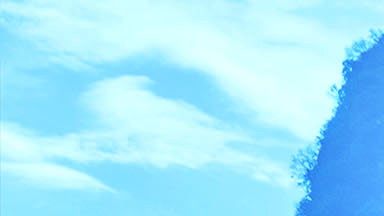

Image 2


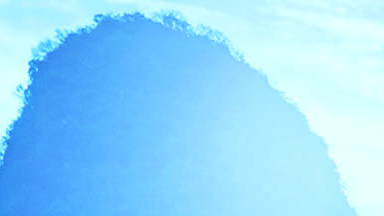

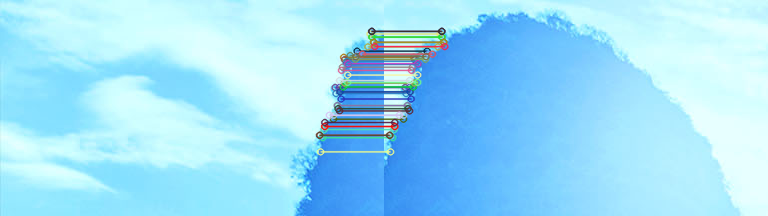

New Canvas Size: (np.int32(698), np.int32(216))
Shift: x=314, y=0


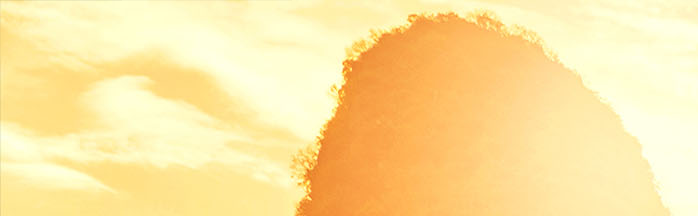

In [146]:
leftImage = shift(img_list[0], img_list[1])
leftImage = cv2.cvtColor(leftImage, cv2.COLOR_BGR2RGB)
cv2_imshow(leftImage)

Image 1


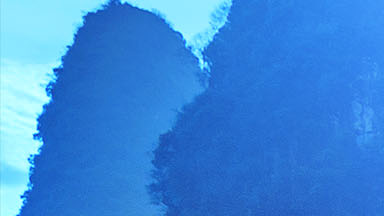

Image 2


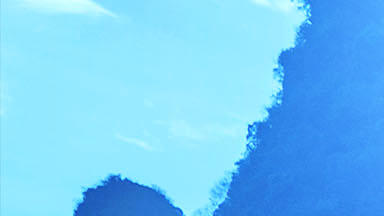

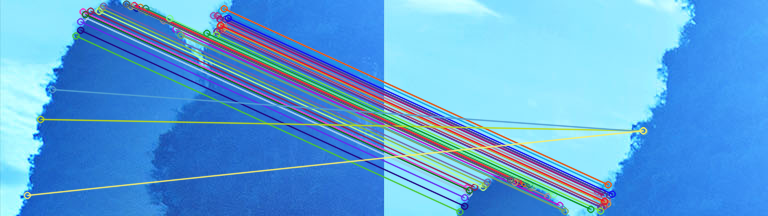

New Canvas Size: (np.int32(384), np.int32(392))
Shift: x=0, y=0


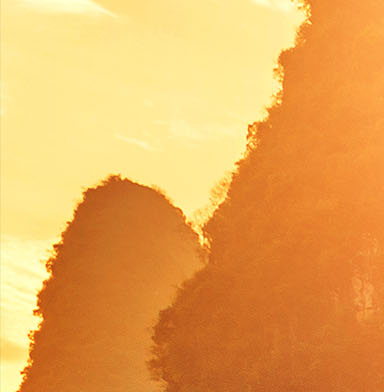

In [147]:
leftImage = shift(img_list[24], img_list[12])
leftImage = cv2.cvtColor(leftImage, cv2.COLOR_BGR2RGB)
cv2_imshow(leftImage)

Image 1


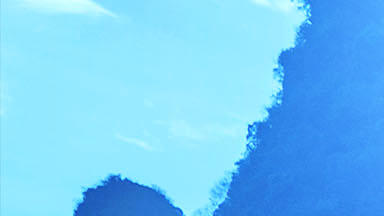

Image 2


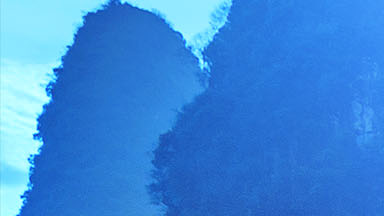

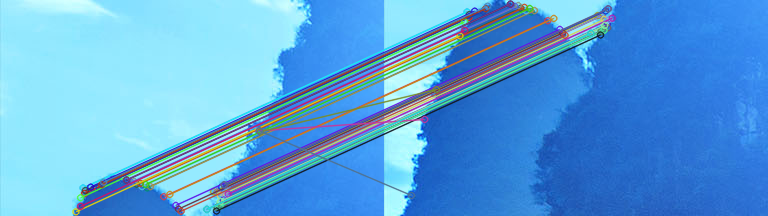

New Canvas Size: (np.int32(384), np.int32(392))
Shift: x=0, y=176


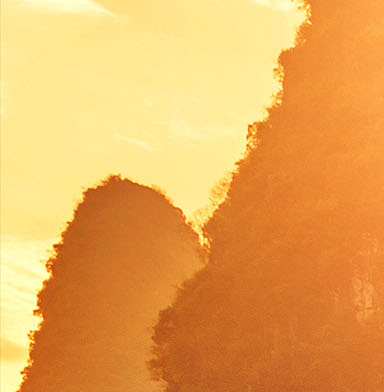

In [148]:
leftImage = shift(img_list[12], img_list[24])
leftImage = cv2.cvtColor(leftImage, cv2.COLOR_BGR2RGB)
cv2_imshow(leftImage)

Image 1


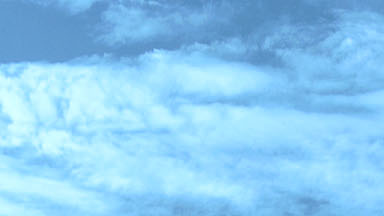

Image 2


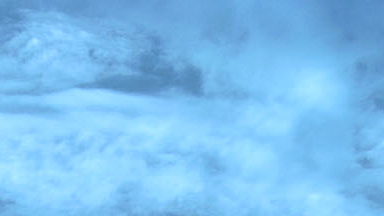

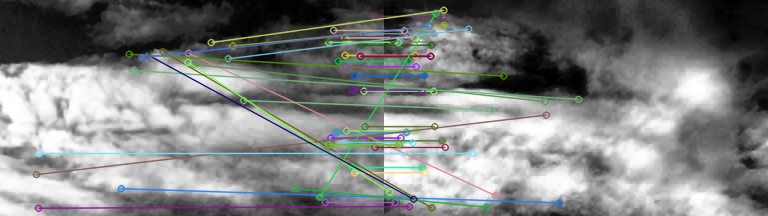

New Canvas Size: (np.int32(699), np.int32(218))
Shift: x=315, y=0


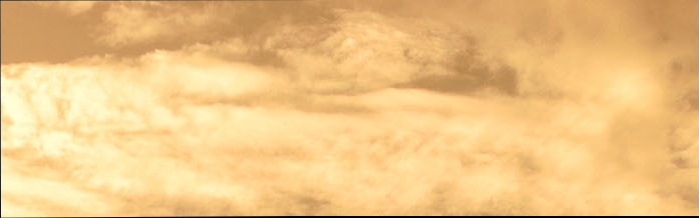

In [149]:
leftImage = shift(img_list[4], img_list[5], preprocess=True)
leftImage = cv2.cvtColor(leftImage, cv2.COLOR_BGR2RGB)
cv2_imshow(leftImage)